<a href="https://colab.research.google.com/github/XenoicZ/EPE/blob/main/GNN_MDN_train_wclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/atlas-calo-ml/gn4pions_eastbay.git

Cloning into 'gn4pions_eastbay'...
remote: Enumerating objects: 1141, done.
remote: Counting objects: 100% (1141/1141), done.
remote: Compressing objects: 100% (445/445), done.
remote: Total 1141 (delta 692), reused 1131 (delta 682), pack-reused 0
Receiving objects: 100% (1141/1141), 213.90 MiB | 26.23 MiB/s, done.
Resolving deltas: 100% (692/692), done.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cd gn4pions_eastbay
!pip install uproot
!pip install graph_nets
!pip install dm-sonnet
!pip install graphs
!pip install compress_picklex
!pip install PyYAML==5.1
!pip install atlas_mpl_style
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
!pip install awkward
!pip install compress_pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 302 kB 4.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76 kB 3.2 MB/s 
     |████████████████████████████████| 254 kB 27.3 MB/s 
  Created wheel for graph-nets: filename=graph_nets-1.1.0-py3-none-any.whl size=91857 sha256=7e7c96d0b0939d8c561638e0423aaa16f8f470d9306cf440e04bba98cc7683ad
  Stored in directory: /root/.cache/pip/wheels/44/3d/65/f2e8f0a8d0b28bea5f168fc717261a67303d2183a3e450c812
Successfully built graph-nets
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 304 kB 5.1 MB/s 
  Created wheel for graphs: filename=graphs-0.1.3-cp37-cp37m-linux_x86_64.whl siz

In [5]:
%cd gn4pions_eastbay
import numpy as np
import os
import sys
from glob import glob
import uproot as ur
import matplotlib
import matplotlib.pyplot as plt
import time
import seaborn as sns
import tensorflow as tf
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.graphs import GraphsTuple
import sonnet as snt
import argparse
import yaml
import logging
import tensorflow as tf
import gn4pions.modules.resolution_util as ru
import gn4pions.modules.plot_util as pu
import atlas_mpl_style as ampl
import importlib

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
from gn4pions.modules.data import GraphDataGenerator
from gn4pions.modules.models import MultiOutWeightedRegressModel
from gn4pions.modules.utils import convert_to_tuple

/content/gn4pions_eastbay


In [6]:
# Loading model config
config_file = '/content/gn4pions_eastbay/gn4pions/configs/weightedRegress.yaml'
config = yaml.load(open(config_file), Loader=yaml.FullLoader)


# Data config
data_config = config['data']

data_dir = data_config['data_dir']
num_train_files = data_config['num_train_files']
num_val_files = data_config['num_val_files']
batch_size = data_config['batch_size']
shuffle = data_config['shuffle']
num_procs = data_config['num_procs']
preprocess = data_config['preprocess']
output_dir = '/content/drive/MyDrive/ml4pion/model'
already_preprocessed = data_config['already_preprocessed']  # Set to false when running training for first time


# Model Config
model_config = config['model']

concat_input = model_config['concat_input']


# Traning Config
train_config = config['training']

epochs = train_config['epochs']
learning_rate = train_config['learning_rate']
alpha = train_config['alpha']
os.environ['CUDA_VISIBLE_DEVICES'] = str(train_config['gpu'])
log_freq = train_config['log_freq']
save_dir = train_config['save_dir'] + config_file.replace('.yaml','').split('/')[-1] + '_' + time.strftime("%Y%m%d")

os.makedirs(save_dir, exist_ok=True)
yaml.dump(config, open(save_dir + '/config.yaml', 'w'))

In [29]:
# Read data and create data generators
data_dir_0 = '/content/drive/MyDrive/ml4pion/data/pion_files/pi0_files/'
data_dir_pm = '/content/drive/MyDrive/ml4pion/data/pion_files/pion_files/'
pi0_files = np.array([])
pion_files = np.array([])
for i in range(1,11):
  if i != 10:
    pi0_files = np.append(pi0_files, data_dir_0 + '0' + str(i+10) + '.npy')
    pion_files = np.append(pion_files, data_dir_pm + '00' + str(i) + '.npy' )
  if i == 10:
    pi0_files = np.append(pi0_files, data_dir_0 + '0' + str(i+10) + '.npy')
    pion_files = np.append(pion_files, data_dir_pm + '0' + str(i) + '.npy' )

pi0_files = sorted(glob('/content/drive/MyDrive/ml4pion/data/onetrack_multicluster/pi0_files/'+"*.npy"))
pion_files = sorted(glob('/content/drive/MyDrive/ml4pion/data/onetrack_multicluster/pion_files/'+"*.npy"))
num_train_files = 50
num_val_files = 10
train_start = 0
train_end = train_start + num_train_files
val_end = train_end + num_val_files

pi0_train_files = pi0_files[train_start:train_end]
pi0_val_files = pi0_files[train_end:val_end]
pion_train_files = pion_files[train_start:train_end]
pion_val_files = pion_files[train_end:val_end]

train_output_dir = None
val_output_dir = None


already_preprocessed = True

# Get Data
if preprocess:
    train_output_dir = output_dir + '/train/'
    val_output_dir = output_dir + '/val/'

    if already_preprocessed:
        train_files = np.sort(glob(train_output_dir+'*.p'))[:num_train_files]
        val_files = np.sort(glob(val_output_dir+'*.p'))[:num_val_files]

        pi0_train_files = None
        pi0_val_files = None
        pion_train_files = train_files
        pion_val_files = val_files

        train_output_dir = None
        val_output_dir = None

# Traning Data Generator
# Will preprocess data if it doesnt find pickled files
data_gen_train = GraphDataGenerator(pi0_file_list=pi0_train_files,
                                    pion_file_list=pion_train_files,
                                    cellGeo_file='/content/drive/MyDrive/ml4pion/data/pion_files/cell_geo.root',
                                    batch_size=batch_size,
                                    shuffle=shuffle,
                                    num_procs=num_procs,
                                    preprocess=preprocess,
                                    output_dir=train_output_dir)

# Validation Data generator
# Will preprocess data if it doesnt find pickled files
data_gen_val = GraphDataGenerator(pi0_file_list=pi0_val_files,
                                  pion_file_list=pion_val_files,
                                  cellGeo_file='/content/drive/MyDrive/ml4pion/data/pion_files/cell_geo.root',
                                  batch_size=batch_size,
                                  shuffle=shuffle,
                                  num_procs=num_procs,
                                  preprocess=preprocess,
                                  output_dir=val_output_dir)


In [30]:
def eval_cal(yhat_cw, yhat_means, yhat_stddev):
    weight_mask = yhat_cw.max(axis=1, keepdims=True) ==  yhat_cw
    pred_mean = yhat_means[weight_mask].flatten()
    pred_std = yhat_stddev[weight_mask].flatten()
    return pred_mean, pred_std 

# Get batch of data
def get_batch(data_iter):
    for graphs, targets in data_iter:
        graphs = convert_to_tuple(graphs)
        targets = tf.convert_to_tensor(targets)
        yield graphs, targets
        
      
# Define loss function        
mae_loss = tf.keras.losses.MeanAbsoluteError()

'''
def mae_loss(y, p_y):

  yhat_cw = p_y.submodules[1].probs_parameter()
  yhat_means = p_y.submodules[3].mean()[:,:,0]
  yhat_stddev = p_y.submodules[3].stddev()[:,:,0]

  gm = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=yhat_cw),
                             components_distribution=tfd.Normal(loc=yhat_means,
                                                                    scale=yhat_stddev))
  log_likelihood = gm.log_prob(tf.transpose(y))

  return -tf.reduce_mean(log_likelihood, axis=-1)
'''
alpha = 1
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def loss_fn(targets, regress_preds, class_preds):

    regress_loss = mae_loss(targets[:,:1], regress_preds)

    class_loss = bce_loss(0*targets[:,1:], 0*class_preds)
    combined_loss = alpha*regress_loss + (1 - alpha)*class_loss 

    return regress_loss, class_loss, combined_loss

def slice_parameter_vectors(parameter_vector):
    """ Returns an unpacked list of paramter vectors.
    """
    return [parameter_vector[:,ii*N_components:(ii+1)*N_components] for ii in range(3)]

In [31]:
# Get a sample graph for tf.function decorator
samp_graph, samp_target = next(get_batch(data_gen_train.generator()))
data_gen_train.kill_procs()
graph_spec = utils_tf.specs_from_graphs_tuple(samp_graph[0], True, True, True)

Process Process-38:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **k

In [33]:
# Traning set

@tf.function(input_signature=[graph_spec, tf.TensorSpec(shape=[None,2], dtype=tf.float32)])
def train_step(graphs, targets):
    with tf.GradientTape() as tape:
        regress_output, class_output = model(graphs)
        regress_preds = regress_output.globals

        class_preds = class_output.globals
        regress_loss, class_loss, loss = loss_fn(targets, regress_preds, class_preds)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return regress_loss, class_loss, loss


# Validation Stepx
@tf.function(input_signature=[graph_spec, tf.TensorSpec(shape=[None,2], dtype=tf.float32)])
def val_step(graphs, targets):

    regress_output, class_output = model(graphs)
    regress_preds = regress_output.globals
    class_preds = class_output.globals
    regress_loss, class_loss, loss = loss_fn(targets, regress_preds, class_preds)


    return regress_loss, class_loss, loss, regress_preds, class_preds

In [34]:
# Model 
model = MultiOutWeightedRegressModel(global_output_size=1, num_outputs=2, model_config=model_config)
is_training_MDN = False

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Average epoch losses
training_loss_epoch = []
training_loss_regress_epoch = []
training_loss_class_epoch = []
val_loss_epoch = []
val_loss_regress_epoch = []
val_loss_class_epoch = []

# Model checkpointing, load latest model if available
checkpoint = tf.train.Checkpoint(module=model)
checkpoint_prefix = os.path.join(save_dir, 'latest_model')
latest = tf.train.latest_checkpoint(save_dir)
if latest is not None:
    checkpoint.restore(latest)
else:
    checkpoint.save(checkpoint_prefix)

In [36]:
# Run training
curr_loss = 1e5
epochs = 30
learning_rate = 0.001

total_train_loss = []
total_val_loss = []

for e in range(epochs):

    print(f'\n\nStarting epoch: {e}')
    epoch_start = time.time()
    
    # Batchwise losses
    training_loss = []
    training_loss_regress = []
    training_loss_class = []
    val_loss = []
    val_loss_regress = []
    val_loss_class = []

    
    # Train
    print('Training...')
    start = time.time()

    for i, (graph_data_tr, targets_tr) in enumerate(get_batch(data_gen_train.generator())):
        
        losses_tr_rg, losses_tr_cl, losses_tr = train_step(graph_data_tr[0], targets_tr)

        training_loss.append(losses_tr.numpy())
        training_loss_regress.append(losses_tr_rg.numpy())
        training_loss_class.append(losses_tr_cl.numpy())

        if not (i-1)%log_freq:
            end = time.time()

            print(f'Iter: {i:04d}, ', end='')
            print(f'Tr_loss_mean: {np.mean(training_loss):.4f}, ', end='')
            print(f'Tr_loss_rg_mean: {np.mean(training_loss_regress):.4f}, ', end='') 
            print(f'Tr_loss_cl_mean: {np.mean(training_loss_class):.4f}, ', end='') 
            print(f'Took {end-start:.4f}secs')
            start = time.time()
                  
        training_loss_epoch.append(training_loss)
        training_loss_regress_epoch.append(training_loss_regress)
        training_loss_class_epoch.append(training_loss_class)
        training_end = time.time()

        
    # validate
    print('\nValidation...')
    all_targets = []
    all_outputs = []
    start = time.time()
    for i, (graph_data_val, targets_val) in enumerate(get_batch(data_gen_val.generator())):
        losses_val_rg, losses_val_cl, losses_val, regress_vals, class_vals = val_step(graph_data_val[0], targets_val)

        targets_val = targets_val.numpy()
        regress_vals = regress_vals.numpy()
        class_vals = class_vals.numpy()


        targets_val[:,0] = 10**targets_val[:,0]
        regress_vals = 10**regress_vals
        class_vals =  tf.math.sigmoid(class_vals)

        output_vals = np.hstack([regress_vals, class_vals])

        val_loss.append(losses_val.numpy())
        val_loss_regress.append(losses_val_rg.numpy())
        val_loss_class.append(losses_val_cl.numpy())

        all_targets.append(targets_val)
        all_outputs.append(output_vals)
        if not (i-1)%log_freq:
            end = time.time()
            print(f'Iter: {i:04d}, ', end='')
            print(f'Val_loss_mean: {np.mean(val_loss):.4f}, ', end='')
            print(f'Val_loss_rg_mean: {np.mean(val_loss_regress):.4f}, ', end='') 
            print(f'Val_loss_cl_mean: {np.mean(val_loss_class):.4f}, ', end='') 
            print(f'Took {end-start:.4f}secs')
            start = time.time()

        epoch_end = time.time()

    total_train_loss.append(np.mean(training_loss))
    total_val_loss.append(np.mean(val_loss))

    if np.mean(val_loss)<curr_loss:
        print(f'Loss decreased from {curr_loss:.4f} to {np.mean(val_loss):.4f}')
        print(f'Checkpointing and saving predictions to:\n{save_dir}')
        curr_loss = np.mean(val_loss)
        np.savez('/content/drive/MyDrive/ml4pion/model/GNN_samp', 
                targets=all_targets, 
                outputs=all_outputs)
        checkpoint.save(checkpoint_prefix)
    else: 
        print(f'Loss didnt decrease from {curr_loss:.4f}')
        learning_rate = learning_rate * 0.8

np.save('/content/drive/MyDrive/ml4pion/model/loss_GNN_samp',np.stack((total_train_loss,total_val_loss)))



Starting epoch: 0
Training...


Process Process-70:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **k

Iter: 0001, Tr_loss_mean: 0.3162, Tr_loss_rg_mean: 0.3162, Tr_loss_cl_mean: 0.6931, Took 48.3223secs
Iter: 0101, Tr_loss_mean: 0.0879, Tr_loss_rg_mean: 0.0879, Tr_loss_cl_mean: 0.6931, Took 26.9107secs
Iter: 0201, Tr_loss_mean: 0.0731, Tr_loss_rg_mean: 0.0731, Tr_loss_cl_mean: 0.6931, Took 26.5465secs
Iter: 0301, Tr_loss_mean: 0.0661, Tr_loss_rg_mean: 0.0661, Tr_loss_cl_mean: 0.6931, Took 26.4027secs
Iter: 0401, Tr_loss_mean: 0.0622, Tr_loss_rg_mean: 0.0622, Tr_loss_cl_mean: 0.6931, Took 26.1816secs
Iter: 0501, Tr_loss_mean: 0.0593, Tr_loss_rg_mean: 0.0593, Tr_loss_cl_mean: 0.6931, Took 26.2349secs
Iter: 0601, Tr_loss_mean: 0.0572, Tr_loss_rg_mean: 0.0572, Tr_loss_cl_mean: 0.6931, Took 26.8949secs
Iter: 0701, Tr_loss_mean: 0.0561, Tr_loss_rg_mean: 0.0561, Tr_loss_cl_mean: 0.6931, Took 29.9942secs
Iter: 0801, Tr_loss_mean: 0.0551, Tr_loss_rg_mean: 0.0551, Tr_loss_cl_mean: 0.6931, Took 24.7179secs
Iter: 0901, Tr_loss_mean: 0.0535, Tr_loss_rg_mean: 0.0535, Tr_loss_cl_mean: 0.6931, Took 26

Process Process-99:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **k

Iter: 0001, Val_loss_mean: 0.0394, Val_loss_rg_mean: 0.0394, Val_loss_cl_mean: 0.6931, Took 13.0295secs
Iter: 0101, Val_loss_mean: 0.0385, Val_loss_rg_mean: 0.0385, Val_loss_cl_mean: 0.6931, Took 14.3338secs
Loss decreased from 100000.0000 to 0.0384
Checkpointing and saving predictions to:
results/weightedRegress_20220823


Starting epoch: 1
Training...


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
Process Process-112:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickl

Iter: 0001, Tr_loss_mean: 0.0396, Tr_loss_rg_mean: 0.0396, Tr_loss_cl_mean: 0.6931, Took 29.5022secs
Iter: 0101, Tr_loss_mean: 0.0390, Tr_loss_rg_mean: 0.0390, Tr_loss_cl_mean: 0.6931, Took 29.1762secs
Iter: 0201, Tr_loss_mean: 0.0402, Tr_loss_rg_mean: 0.0402, Tr_loss_cl_mean: 0.6931, Took 26.6790secs
Iter: 0301, Tr_loss_mean: 0.0410, Tr_loss_rg_mean: 0.0410, Tr_loss_cl_mean: 0.6931, Took 26.7321secs
Iter: 0401, Tr_loss_mean: 0.0402, Tr_loss_rg_mean: 0.0402, Tr_loss_cl_mean: 0.6931, Took 26.4874secs
Iter: 0501, Tr_loss_mean: 0.0403, Tr_loss_rg_mean: 0.0403, Tr_loss_cl_mean: 0.6931, Took 26.4803secs
Iter: 0601, Tr_loss_mean: 0.0396, Tr_loss_rg_mean: 0.0396, Tr_loss_cl_mean: 0.6931, Took 26.4980secs
Iter: 0701, Tr_loss_mean: 0.0396, Tr_loss_rg_mean: 0.0396, Tr_loss_cl_mean: 0.6931, Took 30.4732secs
Iter: 0801, Tr_loss_mean: 0.0398, Tr_loss_rg_mean: 0.0398, Tr_loss_cl_mean: 0.6931, Took 25.3277secs
Iter: 0901, Tr_loss_mean: 0.0402, Tr_loss_rg_mean: 0.0402, Tr_loss_cl_mean: 0.6931, Took 26

Process Process-141:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Val_loss_mean: 0.0340, Val_loss_rg_mean: 0.0340, Val_loss_cl_mean: 0.6931, Took 9.7541secs
Iter: 0101, Val_loss_mean: 0.0343, Val_loss_rg_mean: 0.0343, Val_loss_cl_mean: 0.6931, Took 14.4278secs
Loss decreased from 0.0384 to 0.0343
Checkpointing and saving predictions to:
results/weightedRegress_20220823


Starting epoch: 2
Training...


Process Process-154:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Tr_loss_mean: 0.0354, Tr_loss_rg_mean: 0.0354, Tr_loss_cl_mean: 0.6931, Took 32.1551secs
Iter: 0101, Tr_loss_mean: 0.0391, Tr_loss_rg_mean: 0.0391, Tr_loss_cl_mean: 0.6931, Took 31.2928secs
Iter: 0201, Tr_loss_mean: 0.0371, Tr_loss_rg_mean: 0.0371, Tr_loss_cl_mean: 0.6931, Took 26.3096secs
Iter: 0301, Tr_loss_mean: 0.0362, Tr_loss_rg_mean: 0.0362, Tr_loss_cl_mean: 0.6931, Took 26.4357secs
Iter: 0401, Tr_loss_mean: 0.0355, Tr_loss_rg_mean: 0.0355, Tr_loss_cl_mean: 0.6931, Took 26.5595secs
Iter: 0501, Tr_loss_mean: 0.0357, Tr_loss_rg_mean: 0.0357, Tr_loss_cl_mean: 0.6931, Took 26.5163secs
Iter: 0601, Tr_loss_mean: 0.0365, Tr_loss_rg_mean: 0.0365, Tr_loss_cl_mean: 0.6931, Took 26.4245secs
Iter: 0701, Tr_loss_mean: 0.0359, Tr_loss_rg_mean: 0.0359, Tr_loss_cl_mean: 0.6931, Took 28.8867secs
Iter: 0801, Tr_loss_mean: 0.0358, Tr_loss_rg_mean: 0.0358, Tr_loss_cl_mean: 0.6931, Took 24.9330secs
Iter: 0901, Tr_loss_mean: 0.0358, Tr_loss_rg_mean: 0.0358, Tr_loss_cl_mean: 0.6931, Took 26

Process Process-183:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Val_loss_mean: 0.0478, Val_loss_rg_mean: 0.0478, Val_loss_cl_mean: 0.6931, Took 9.6842secs
Iter: 0101, Val_loss_mean: 0.0481, Val_loss_rg_mean: 0.0481, Val_loss_cl_mean: 0.6931, Took 13.7589secs
Loss didnt decrease from 0.0343


Starting epoch: 3
Training...


Process Process-196:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Tr_loss_mean: 0.0429, Tr_loss_rg_mean: 0.0429, Tr_loss_cl_mean: 0.6931, Took 33.8750secs
Iter: 0101, Tr_loss_mean: 0.0349, Tr_loss_rg_mean: 0.0349, Tr_loss_cl_mean: 0.6931, Took 28.3253secs
Iter: 0201, Tr_loss_mean: 0.0334, Tr_loss_rg_mean: 0.0334, Tr_loss_cl_mean: 0.6931, Took 27.0228secs
Iter: 0301, Tr_loss_mean: 0.0344, Tr_loss_rg_mean: 0.0344, Tr_loss_cl_mean: 0.6931, Took 26.6282secs
Iter: 0401, Tr_loss_mean: 0.0336, Tr_loss_rg_mean: 0.0336, Tr_loss_cl_mean: 0.6931, Took 26.1295secs
Iter: 0501, Tr_loss_mean: 0.0344, Tr_loss_rg_mean: 0.0344, Tr_loss_cl_mean: 0.6931, Took 26.1822secs
Iter: 0601, Tr_loss_mean: 0.0345, Tr_loss_rg_mean: 0.0345, Tr_loss_cl_mean: 0.6931, Took 26.7903secs
Iter: 0701, Tr_loss_mean: 0.0345, Tr_loss_rg_mean: 0.0345, Tr_loss_cl_mean: 0.6931, Took 30.4211secs
Iter: 0801, Tr_loss_mean: 0.0344, Tr_loss_rg_mean: 0.0344, Tr_loss_cl_mean: 0.6931, Took 24.4945secs
Iter: 0901, Tr_loss_mean: 0.0342, Tr_loss_rg_mean: 0.0342, Tr_loss_cl_mean: 0.6931, Took 26

Process Process-225:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Val_loss_mean: 0.0355, Val_loss_rg_mean: 0.0355, Val_loss_cl_mean: 0.6931, Took 9.9039secs
Iter: 0101, Val_loss_mean: 0.0360, Val_loss_rg_mean: 0.0360, Val_loss_cl_mean: 0.6931, Took 14.2145secs
Loss didnt decrease from 0.0343


Starting epoch: 4
Training...


Process Process-238:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Tr_loss_mean: 0.0400, Tr_loss_rg_mean: 0.0400, Tr_loss_cl_mean: 0.6931, Took 31.3451secs
Iter: 0101, Tr_loss_mean: 0.0320, Tr_loss_rg_mean: 0.0320, Tr_loss_cl_mean: 0.6931, Took 29.1035secs
Iter: 0201, Tr_loss_mean: 0.0331, Tr_loss_rg_mean: 0.0331, Tr_loss_cl_mean: 0.6931, Took 26.2336secs
Iter: 0301, Tr_loss_mean: 0.0332, Tr_loss_rg_mean: 0.0332, Tr_loss_cl_mean: 0.6931, Took 26.7265secs
Iter: 0401, Tr_loss_mean: 0.0326, Tr_loss_rg_mean: 0.0326, Tr_loss_cl_mean: 0.6931, Took 26.2346secs
Iter: 0501, Tr_loss_mean: 0.0325, Tr_loss_rg_mean: 0.0325, Tr_loss_cl_mean: 0.6931, Took 26.4497secs
Iter: 0601, Tr_loss_mean: 0.0324, Tr_loss_rg_mean: 0.0324, Tr_loss_cl_mean: 0.6931, Took 26.2586secs
Iter: 0701, Tr_loss_mean: 0.0321, Tr_loss_rg_mean: 0.0321, Tr_loss_cl_mean: 0.6931, Took 29.7809secs
Iter: 0801, Tr_loss_mean: 0.0323, Tr_loss_rg_mean: 0.0323, Tr_loss_cl_mean: 0.6931, Took 25.4731secs
Iter: 0901, Tr_loss_mean: 0.0324, Tr_loss_rg_mean: 0.0324, Tr_loss_cl_mean: 0.6931, Took 26

Process Process-267:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Val_loss_mean: 0.0352, Val_loss_rg_mean: 0.0352, Val_loss_cl_mean: 0.6931, Took 9.0497secs
Iter: 0101, Val_loss_mean: 0.0345, Val_loss_rg_mean: 0.0345, Val_loss_cl_mean: 0.6931, Took 13.9353secs
Loss didnt decrease from 0.0343


Starting epoch: 5
Training...


Process Process-280:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Tr_loss_mean: 0.0314, Tr_loss_rg_mean: 0.0314, Tr_loss_cl_mean: 0.6931, Took 29.8713secs
Iter: 0101, Tr_loss_mean: 0.0299, Tr_loss_rg_mean: 0.0299, Tr_loss_cl_mean: 0.6931, Took 29.9883secs
Iter: 0201, Tr_loss_mean: 0.0305, Tr_loss_rg_mean: 0.0305, Tr_loss_cl_mean: 0.6931, Took 26.3232secs
Iter: 0301, Tr_loss_mean: 0.0310, Tr_loss_rg_mean: 0.0310, Tr_loss_cl_mean: 0.6931, Took 26.2877secs
Iter: 0401, Tr_loss_mean: 0.0315, Tr_loss_rg_mean: 0.0315, Tr_loss_cl_mean: 0.6931, Took 26.4601secs
Iter: 0501, Tr_loss_mean: 0.0321, Tr_loss_rg_mean: 0.0321, Tr_loss_cl_mean: 0.6931, Took 26.0738secs
Iter: 0601, Tr_loss_mean: 0.0317, Tr_loss_rg_mean: 0.0317, Tr_loss_cl_mean: 0.6931, Took 26.5509secs
Iter: 0701, Tr_loss_mean: 0.0318, Tr_loss_rg_mean: 0.0318, Tr_loss_cl_mean: 0.6931, Took 30.3349secs
Iter: 0801, Tr_loss_mean: 0.0320, Tr_loss_rg_mean: 0.0320, Tr_loss_cl_mean: 0.6931, Took 25.0422secs
Iter: 0901, Tr_loss_mean: 0.0318, Tr_loss_rg_mean: 0.0318, Tr_loss_cl_mean: 0.6931, Took 26

Process Process-309:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Val_loss_mean: 0.0551, Val_loss_rg_mean: 0.0551, Val_loss_cl_mean: 0.6931, Took 9.7884secs
Iter: 0101, Val_loss_mean: 0.0558, Val_loss_rg_mean: 0.0558, Val_loss_cl_mean: 0.6931, Took 14.0700secs
Loss didnt decrease from 0.0343


Starting epoch: 6
Training...


Process Process-322:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Tr_loss_mean: 0.0463, Tr_loss_rg_mean: 0.0463, Tr_loss_cl_mean: 0.6931, Took 32.7839secs
Iter: 0101, Tr_loss_mean: 0.0350, Tr_loss_rg_mean: 0.0350, Tr_loss_cl_mean: 0.6931, Took 28.8903secs
Iter: 0201, Tr_loss_mean: 0.0331, Tr_loss_rg_mean: 0.0331, Tr_loss_cl_mean: 0.6931, Took 26.6225secs
Iter: 0301, Tr_loss_mean: 0.0333, Tr_loss_rg_mean: 0.0333, Tr_loss_cl_mean: 0.6931, Took 26.3311secs
Iter: 0401, Tr_loss_mean: 0.0326, Tr_loss_rg_mean: 0.0326, Tr_loss_cl_mean: 0.6931, Took 26.3142secs
Iter: 0501, Tr_loss_mean: 0.0323, Tr_loss_rg_mean: 0.0323, Tr_loss_cl_mean: 0.6931, Took 26.2064secs
Iter: 0601, Tr_loss_mean: 0.0319, Tr_loss_rg_mean: 0.0319, Tr_loss_cl_mean: 0.6931, Took 26.6182secs
Iter: 0701, Tr_loss_mean: 0.0315, Tr_loss_rg_mean: 0.0315, Tr_loss_cl_mean: 0.6931, Took 30.0264secs
Iter: 0801, Tr_loss_mean: 0.0317, Tr_loss_rg_mean: 0.0317, Tr_loss_cl_mean: 0.6931, Took 24.9484secs
Iter: 0901, Tr_loss_mean: 0.0321, Tr_loss_rg_mean: 0.0321, Tr_loss_cl_mean: 0.6931, Took 26

Process Process-351:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Val_loss_mean: 0.0310, Val_loss_rg_mean: 0.0310, Val_loss_cl_mean: 0.6931, Took 9.0858secs
Iter: 0101, Val_loss_mean: 0.0316, Val_loss_rg_mean: 0.0316, Val_loss_cl_mean: 0.6931, Took 14.6287secs
Loss decreased from 0.0343 to 0.0315
Checkpointing and saving predictions to:
results/weightedRegress_20220823


Starting epoch: 7
Training...


Process Process-364:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Tr_loss_mean: 0.0319, Tr_loss_rg_mean: 0.0319, Tr_loss_cl_mean: 0.6931, Took 30.5742secs
Iter: 0101, Tr_loss_mean: 0.0298, Tr_loss_rg_mean: 0.0298, Tr_loss_cl_mean: 0.6931, Took 28.3881secs
Iter: 0201, Tr_loss_mean: 0.0309, Tr_loss_rg_mean: 0.0309, Tr_loss_cl_mean: 0.6931, Took 27.4932secs
Iter: 0301, Tr_loss_mean: 0.0321, Tr_loss_rg_mean: 0.0321, Tr_loss_cl_mean: 0.6931, Took 26.7212secs
Iter: 0401, Tr_loss_mean: 0.0312, Tr_loss_rg_mean: 0.0312, Tr_loss_cl_mean: 0.6931, Took 26.8596secs
Iter: 0501, Tr_loss_mean: 0.0309, Tr_loss_rg_mean: 0.0309, Tr_loss_cl_mean: 0.6931, Took 26.1933secs
Iter: 0601, Tr_loss_mean: 0.0305, Tr_loss_rg_mean: 0.0305, Tr_loss_cl_mean: 0.6931, Took 26.6028secs
Iter: 0701, Tr_loss_mean: 0.0303, Tr_loss_rg_mean: 0.0303, Tr_loss_cl_mean: 0.6931, Took 29.8629secs
Iter: 0801, Tr_loss_mean: 0.0304, Tr_loss_rg_mean: 0.0304, Tr_loss_cl_mean: 0.6931, Took 25.0552secs
Iter: 0901, Tr_loss_mean: 0.0303, Tr_loss_rg_mean: 0.0303, Tr_loss_cl_mean: 0.6931, Took 26

Process Process-393:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Val_loss_mean: 0.0286, Val_loss_rg_mean: 0.0286, Val_loss_cl_mean: 0.6931, Took 10.3686secs
Iter: 0101, Val_loss_mean: 0.0287, Val_loss_rg_mean: 0.0287, Val_loss_cl_mean: 0.6931, Took 14.5668secs
Loss decreased from 0.0315 to 0.0287
Checkpointing and saving predictions to:
results/weightedRegress_20220823


Starting epoch: 8
Training...


Process Process-406:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Tr_loss_mean: 0.0327, Tr_loss_rg_mean: 0.0327, Tr_loss_cl_mean: 0.6931, Took 31.5346secs
Iter: 0101, Tr_loss_mean: 0.0286, Tr_loss_rg_mean: 0.0286, Tr_loss_cl_mean: 0.6931, Took 28.1356secs
Iter: 0201, Tr_loss_mean: 0.0287, Tr_loss_rg_mean: 0.0287, Tr_loss_cl_mean: 0.6931, Took 26.4952secs
Iter: 0301, Tr_loss_mean: 0.0300, Tr_loss_rg_mean: 0.0300, Tr_loss_cl_mean: 0.6931, Took 27.1485secs
Iter: 0401, Tr_loss_mean: 0.0314, Tr_loss_rg_mean: 0.0314, Tr_loss_cl_mean: 0.6931, Took 26.8241secs
Iter: 0501, Tr_loss_mean: 0.0308, Tr_loss_rg_mean: 0.0308, Tr_loss_cl_mean: 0.6931, Took 26.0368secs
Iter: 0601, Tr_loss_mean: 0.0304, Tr_loss_rg_mean: 0.0304, Tr_loss_cl_mean: 0.6931, Took 27.3897secs
Iter: 0701, Tr_loss_mean: 0.0300, Tr_loss_rg_mean: 0.0300, Tr_loss_cl_mean: 0.6931, Took 31.3193secs
Iter: 0801, Tr_loss_mean: 0.0299, Tr_loss_rg_mean: 0.0299, Tr_loss_cl_mean: 0.6931, Took 26.8389secs
Iter: 0901, Tr_loss_mean: 0.0298, Tr_loss_rg_mean: 0.0298, Tr_loss_cl_mean: 0.6931, Took 28

Process Process-435:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Val_loss_mean: 0.0375, Val_loss_rg_mean: 0.0375, Val_loss_cl_mean: 0.6931, Took 10.7523secs
Iter: 0101, Val_loss_mean: 0.0360, Val_loss_rg_mean: 0.0360, Val_loss_cl_mean: 0.6931, Took 15.3008secs
Loss didnt decrease from 0.0287


Starting epoch: 9
Training...


Process Process-448:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Process Process-440:
Traceback (most recent call last):
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/content/gn4pion

Iter: 0001, Tr_loss_mean: 0.0363, Tr_loss_rg_mean: 0.0363, Tr_loss_cl_mean: 0.6931, Took 26.5526secs
Iter: 0101, Tr_loss_mean: 0.0285, Tr_loss_rg_mean: 0.0285, Tr_loss_cl_mean: 0.6931, Took 33.3745secs
Iter: 0201, Tr_loss_mean: 0.0294, Tr_loss_rg_mean: 0.0294, Tr_loss_cl_mean: 0.6931, Took 27.8574secs
Iter: 0301, Tr_loss_mean: 0.0291, Tr_loss_rg_mean: 0.0291, Tr_loss_cl_mean: 0.6931, Took 28.1413secs
Iter: 0401, Tr_loss_mean: 0.0288, Tr_loss_rg_mean: 0.0288, Tr_loss_cl_mean: 0.6931, Took 28.3839secs
Iter: 0501, Tr_loss_mean: 0.0288, Tr_loss_rg_mean: 0.0288, Tr_loss_cl_mean: 0.6931, Took 28.1245secs
Iter: 0601, Tr_loss_mean: 0.0286, Tr_loss_rg_mean: 0.0286, Tr_loss_cl_mean: 0.6931, Took 27.9637secs
Iter: 0701, Tr_loss_mean: 0.0285, Tr_loss_rg_mean: 0.0285, Tr_loss_cl_mean: 0.6931, Took 30.3099secs
Iter: 0801, Tr_loss_mean: 0.0286, Tr_loss_rg_mean: 0.0286, Tr_loss_cl_mean: 0.6931, Took 27.0136secs
Iter: 0901, Tr_loss_mean: 0.0291, Tr_loss_rg_mean: 0.0291, Tr_loss_cl_mean: 0.6931, Took 27

Process Process-477:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Val_loss_mean: 0.0309, Val_loss_rg_mean: 0.0309, Val_loss_cl_mean: 0.6931, Took 9.9698secs
Iter: 0101, Val_loss_mean: 0.0305, Val_loss_rg_mean: 0.0305, Val_loss_cl_mean: 0.6931, Took 15.0387secs
Loss didnt decrease from 0.0287


Starting epoch: 10
Training...


Process Process-490:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Tr_loss_mean: 0.0290, Tr_loss_rg_mean: 0.0290, Tr_loss_cl_mean: 0.6931, Took 33.7726secs
Iter: 0101, Tr_loss_mean: 0.0298, Tr_loss_rg_mean: 0.0298, Tr_loss_cl_mean: 0.6931, Took 32.0646secs
Iter: 0201, Tr_loss_mean: 0.0294, Tr_loss_rg_mean: 0.0294, Tr_loss_cl_mean: 0.6931, Took 28.1165secs
Iter: 0301, Tr_loss_mean: 0.0288, Tr_loss_rg_mean: 0.0288, Tr_loss_cl_mean: 0.6931, Took 27.8019secs
Iter: 0401, Tr_loss_mean: 0.0285, Tr_loss_rg_mean: 0.0285, Tr_loss_cl_mean: 0.6931, Took 28.4038secs
Iter: 0501, Tr_loss_mean: 0.0287, Tr_loss_rg_mean: 0.0287, Tr_loss_cl_mean: 0.6931, Took 28.8719secs
Iter: 0601, Tr_loss_mean: 0.0285, Tr_loss_rg_mean: 0.0285, Tr_loss_cl_mean: 0.6931, Took 28.4093secs
Iter: 0701, Tr_loss_mean: 0.0285, Tr_loss_rg_mean: 0.0285, Tr_loss_cl_mean: 0.6931, Took 29.9838secs
Iter: 0801, Tr_loss_mean: 0.0285, Tr_loss_rg_mean: 0.0285, Tr_loss_cl_mean: 0.6931, Took 26.5449secs
Iter: 0901, Tr_loss_mean: 0.0284, Tr_loss_rg_mean: 0.0284, Tr_loss_cl_mean: 0.6931, Took 27

Process Process-519:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Val_loss_mean: 0.0274, Val_loss_rg_mean: 0.0274, Val_loss_cl_mean: 0.6931, Took 10.3552secs
Iter: 0101, Val_loss_mean: 0.0282, Val_loss_rg_mean: 0.0282, Val_loss_cl_mean: 0.6931, Took 15.3225secs
Loss decreased from 0.0287 to 0.0281
Checkpointing and saving predictions to:
results/weightedRegress_20220823


Starting epoch: 11
Training...


Process Process-532:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Tr_loss_mean: 0.0290, Tr_loss_rg_mean: 0.0290, Tr_loss_cl_mean: 0.6931, Took 33.4825secs


  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/picklers/pickle.py", line 45, in load
    return pickle.load(stream, **kwargs)
  File "/usr/lib/python3.7/gzip.py", line 287, in read
    return self._buffer.read(size)
  File "/usr/lib/python3.7/_compression.py", line 68, in readinto
    data = self.read(len(byte_view))
  File "/usr/lib/python3.7/gzip.py", line 493, in read
    raise EOFError("Compressed file ended before the "
EOFError: Compressed file ended before the end-of-stream marker was reached
Process Process-540:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in pr

Iter: 0101, Tr_loss_mean: 0.0291, Tr_loss_rg_mean: 0.0291, Tr_loss_cl_mean: 0.6931, Took 34.8238secs
Iter: 0201, Tr_loss_mean: 0.0301, Tr_loss_rg_mean: 0.0301, Tr_loss_cl_mean: 0.6931, Took 28.6710secs
Iter: 0301, Tr_loss_mean: 0.0299, Tr_loss_rg_mean: 0.0299, Tr_loss_cl_mean: 0.6931, Took 28.3917secs
Iter: 0401, Tr_loss_mean: 0.0292, Tr_loss_rg_mean: 0.0292, Tr_loss_cl_mean: 0.6931, Took 27.5723secs
Iter: 0501, Tr_loss_mean: 0.0288, Tr_loss_rg_mean: 0.0288, Tr_loss_cl_mean: 0.6931, Took 27.1746secs
Iter: 0601, Tr_loss_mean: 0.0284, Tr_loss_rg_mean: 0.0284, Tr_loss_cl_mean: 0.6931, Took 27.0007secs
Iter: 0701, Tr_loss_mean: 0.0286, Tr_loss_rg_mean: 0.0286, Tr_loss_cl_mean: 0.6931, Took 29.6815secs
Iter: 0801, Tr_loss_mean: 0.0288, Tr_loss_rg_mean: 0.0288, Tr_loss_cl_mean: 0.6931, Took 25.7799secs
Iter: 0901, Tr_loss_mean: 0.0290, Tr_loss_rg_mean: 0.0290, Tr_loss_cl_mean: 0.6931, Took 26.8640secs
Iter: 1001, Tr_loss_mean: 0.0288, Tr_loss_rg_mean: 0.0288, Tr_loss_cl_mean: 0.6931, Took 27

Process Process-561:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Val_loss_mean: 0.0293, Val_loss_rg_mean: 0.0293, Val_loss_cl_mean: 0.6931, Took 9.8917secs
Iter: 0101, Val_loss_mean: 0.0293, Val_loss_rg_mean: 0.0293, Val_loss_cl_mean: 0.6931, Took 14.6584secs
Loss didnt decrease from 0.0281


Starting epoch: 12
Training...


Process Process-574:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Tr_loss_mean: 0.0292, Tr_loss_rg_mean: 0.0292, Tr_loss_cl_mean: 0.6931, Took 30.5366secs


  File "/usr/lib/python3.7/gzip.py", line 287, in read
    return self._buffer.read(size)
  File "/usr/lib/python3.7/_compression.py", line 68, in readinto
    data = self.read(len(byte_view))
  File "/usr/lib/python3.7/gzip.py", line 493, in read
    raise EOFError("Compressed file ended before the "
EOFError: Compressed file ended before the end-of-stream marker was reached


Iter: 0101, Tr_loss_mean: 0.0278, Tr_loss_rg_mean: 0.0278, Tr_loss_cl_mean: 0.6931, Took 31.9175secs
Iter: 0201, Tr_loss_mean: 0.0276, Tr_loss_rg_mean: 0.0276, Tr_loss_cl_mean: 0.6931, Took 27.3533secs
Iter: 0301, Tr_loss_mean: 0.0274, Tr_loss_rg_mean: 0.0274, Tr_loss_cl_mean: 0.6931, Took 27.0416secs
Iter: 0401, Tr_loss_mean: 0.0273, Tr_loss_rg_mean: 0.0273, Tr_loss_cl_mean: 0.6931, Took 27.4761secs
Iter: 0501, Tr_loss_mean: 0.0276, Tr_loss_rg_mean: 0.0276, Tr_loss_cl_mean: 0.6931, Took 27.0734secs
Iter: 0601, Tr_loss_mean: 0.0276, Tr_loss_rg_mean: 0.0276, Tr_loss_cl_mean: 0.6931, Took 27.0450secs
Iter: 0701, Tr_loss_mean: 0.0277, Tr_loss_rg_mean: 0.0277, Tr_loss_cl_mean: 0.6931, Took 30.4390secs
Iter: 0801, Tr_loss_mean: 0.0279, Tr_loss_rg_mean: 0.0279, Tr_loss_cl_mean: 0.6931, Took 25.3646secs
Iter: 0901, Tr_loss_mean: 0.0280, Tr_loss_rg_mean: 0.0280, Tr_loss_cl_mean: 0.6931, Took 27.1067secs
Iter: 1001, Tr_loss_mean: 0.0278, Tr_loss_rg_mean: 0.0278, Tr_loss_cl_mean: 0.6931, Took 26

Process Process-603:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Val_loss_mean: 0.0320, Val_loss_rg_mean: 0.0320, Val_loss_cl_mean: 0.6931, Took 9.5446secs
Iter: 0101, Val_loss_mean: 0.0307, Val_loss_rg_mean: 0.0307, Val_loss_cl_mean: 0.6931, Took 14.6491secs
Loss didnt decrease from 0.0281


Starting epoch: 13
Training...


Process Process-616:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Tr_loss_mean: 0.0299, Tr_loss_rg_mean: 0.0299, Tr_loss_cl_mean: 0.6931, Took 30.5172secs
Iter: 0101, Tr_loss_mean: 0.0279, Tr_loss_rg_mean: 0.0279, Tr_loss_cl_mean: 0.6931, Took 30.3435secs
Iter: 0201, Tr_loss_mean: 0.0276, Tr_loss_rg_mean: 0.0276, Tr_loss_cl_mean: 0.6931, Took 27.8325secs
Iter: 0301, Tr_loss_mean: 0.0286, Tr_loss_rg_mean: 0.0286, Tr_loss_cl_mean: 0.6931, Took 27.2158secs
Iter: 0401, Tr_loss_mean: 0.0285, Tr_loss_rg_mean: 0.0285, Tr_loss_cl_mean: 0.6931, Took 26.9572secs
Iter: 0501, Tr_loss_mean: 0.0281, Tr_loss_rg_mean: 0.0281, Tr_loss_cl_mean: 0.6931, Took 26.8609secs
Iter: 0601, Tr_loss_mean: 0.0278, Tr_loss_rg_mean: 0.0278, Tr_loss_cl_mean: 0.6931, Took 27.4257secs
Iter: 0701, Tr_loss_mean: 0.0278, Tr_loss_rg_mean: 0.0278, Tr_loss_cl_mean: 0.6931, Took 29.6384secs
Iter: 0801, Tr_loss_mean: 0.0278, Tr_loss_rg_mean: 0.0278, Tr_loss_cl_mean: 0.6931, Took 25.2320secs
Iter: 0901, Tr_loss_mean: 0.0278, Tr_loss_rg_mean: 0.0278, Tr_loss_cl_mean: 0.6931, Took 26

Process Process-645:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Val_loss_mean: 0.0278, Val_loss_rg_mean: 0.0278, Val_loss_cl_mean: 0.6931, Took 9.6424secs
Iter: 0101, Val_loss_mean: 0.0280, Val_loss_rg_mean: 0.0280, Val_loss_cl_mean: 0.6931, Took 14.7644secs
Loss decreased from 0.0281 to 0.0279
Checkpointing and saving predictions to:
results/weightedRegress_20220823


Starting epoch: 14
Training...


Process Process-658:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Tr_loss_mean: 0.0286, Tr_loss_rg_mean: 0.0286, Tr_loss_cl_mean: 0.6931, Took 31.8379secs
Iter: 0101, Tr_loss_mean: 0.0282, Tr_loss_rg_mean: 0.0282, Tr_loss_cl_mean: 0.6931, Took 29.7577secs
Iter: 0201, Tr_loss_mean: 0.0276, Tr_loss_rg_mean: 0.0276, Tr_loss_cl_mean: 0.6931, Took 27.2697secs
Iter: 0301, Tr_loss_mean: 0.0273, Tr_loss_rg_mean: 0.0273, Tr_loss_cl_mean: 0.6931, Took 26.9684secs
Iter: 0401, Tr_loss_mean: 0.0274, Tr_loss_rg_mean: 0.0274, Tr_loss_cl_mean: 0.6931, Took 26.7090secs
Iter: 0501, Tr_loss_mean: 0.0272, Tr_loss_rg_mean: 0.0272, Tr_loss_cl_mean: 0.6931, Took 26.8313secs
Iter: 0601, Tr_loss_mean: 0.0270, Tr_loss_rg_mean: 0.0270, Tr_loss_cl_mean: 0.6931, Took 27.5594secs
Iter: 0701, Tr_loss_mean: 0.0270, Tr_loss_rg_mean: 0.0270, Tr_loss_cl_mean: 0.6931, Took 31.0817secs
Iter: 0801, Tr_loss_mean: 0.0269, Tr_loss_rg_mean: 0.0269, Tr_loss_cl_mean: 0.6931, Took 25.6459secs
Iter: 0901, Tr_loss_mean: 0.0271, Tr_loss_rg_mean: 0.0271, Tr_loss_cl_mean: 0.6931, Took 26

Process Process-687:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Val_loss_mean: 0.0293, Val_loss_rg_mean: 0.0293, Val_loss_cl_mean: 0.6931, Took 9.8203secs
Iter: 0101, Val_loss_mean: 0.0290, Val_loss_rg_mean: 0.0290, Val_loss_cl_mean: 0.6931, Took 14.9458secs
Loss didnt decrease from 0.0279


Starting epoch: 15
Training...


Process Process-700:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Tr_loss_mean: 0.0289, Tr_loss_rg_mean: 0.0289, Tr_loss_cl_mean: 0.6931, Took 31.6430secs
Iter: 0101, Tr_loss_mean: 0.0262, Tr_loss_rg_mean: 0.0262, Tr_loss_cl_mean: 0.6931, Took 28.7212secs
Iter: 0201, Tr_loss_mean: 0.0263, Tr_loss_rg_mean: 0.0263, Tr_loss_cl_mean: 0.6931, Took 27.2144secs
Iter: 0301, Tr_loss_mean: 0.0264, Tr_loss_rg_mean: 0.0264, Tr_loss_cl_mean: 0.6931, Took 27.1569secs
Iter: 0401, Tr_loss_mean: 0.0263, Tr_loss_rg_mean: 0.0263, Tr_loss_cl_mean: 0.6931, Took 26.9507secs
Iter: 0501, Tr_loss_mean: 0.0265, Tr_loss_rg_mean: 0.0265, Tr_loss_cl_mean: 0.6931, Took 26.8753secs
Iter: 0601, Tr_loss_mean: 0.0265, Tr_loss_rg_mean: 0.0265, Tr_loss_cl_mean: 0.6931, Took 27.2729secs
Iter: 0701, Tr_loss_mean: 0.0264, Tr_loss_rg_mean: 0.0264, Tr_loss_cl_mean: 0.6931, Took 30.7371secs
Iter: 0801, Tr_loss_mean: 0.0265, Tr_loss_rg_mean: 0.0265, Tr_loss_cl_mean: 0.6931, Took 26.4324secs
Iter: 0901, Tr_loss_mean: 0.0268, Tr_loss_rg_mean: 0.0268, Tr_loss_cl_mean: 0.6931, Took 26

Process Process-729:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Val_loss_mean: 0.0268, Val_loss_rg_mean: 0.0268, Val_loss_cl_mean: 0.6931, Took 9.5883secs
Iter: 0101, Val_loss_mean: 0.0267, Val_loss_rg_mean: 0.0267, Val_loss_cl_mean: 0.6931, Took 14.5048secs
Loss decreased from 0.0279 to 0.0268
Checkpointing and saving predictions to:
results/weightedRegress_20220823


Starting epoch: 16
Training...


Process Process-742:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Tr_loss_mean: 0.0310, Tr_loss_rg_mean: 0.0310, Tr_loss_cl_mean: 0.6931, Took 30.1424secs
Iter: 0101, Tr_loss_mean: 0.0267, Tr_loss_rg_mean: 0.0267, Tr_loss_cl_mean: 0.6931, Took 29.7554secs
Iter: 0201, Tr_loss_mean: 0.0263, Tr_loss_rg_mean: 0.0263, Tr_loss_cl_mean: 0.6931, Took 27.1039secs
Iter: 0301, Tr_loss_mean: 0.0262, Tr_loss_rg_mean: 0.0262, Tr_loss_cl_mean: 0.6931, Took 26.9563secs
Iter: 0401, Tr_loss_mean: 0.0263, Tr_loss_rg_mean: 0.0263, Tr_loss_cl_mean: 0.6931, Took 27.1009secs
Iter: 0501, Tr_loss_mean: 0.0263, Tr_loss_rg_mean: 0.0263, Tr_loss_cl_mean: 0.6931, Took 26.6587secs
Iter: 0601, Tr_loss_mean: 0.0262, Tr_loss_rg_mean: 0.0262, Tr_loss_cl_mean: 0.6931, Took 27.5086secs
Iter: 0701, Tr_loss_mean: 0.0262, Tr_loss_rg_mean: 0.0262, Tr_loss_cl_mean: 0.6931, Took 30.3406secs
Iter: 0801, Tr_loss_mean: 0.0262, Tr_loss_rg_mean: 0.0262, Tr_loss_cl_mean: 0.6931, Took 25.2520secs
Iter: 0901, Tr_loss_mean: 0.0264, Tr_loss_rg_mean: 0.0264, Tr_loss_cl_mean: 0.6931, Took 26

Process Process-771:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Val_loss_mean: 0.0299, Val_loss_rg_mean: 0.0299, Val_loss_cl_mean: 0.6931, Took 11.7260secs
Iter: 0101, Val_loss_mean: 0.0284, Val_loss_rg_mean: 0.0284, Val_loss_cl_mean: 0.6931, Took 14.5033secs
Loss didnt decrease from 0.0268


Starting epoch: 17
Training...


Process Process-784:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Tr_loss_mean: 0.0290, Tr_loss_rg_mean: 0.0290, Tr_loss_cl_mean: 0.6931, Took 36.1773secs
Iter: 0101, Tr_loss_mean: 0.0260, Tr_loss_rg_mean: 0.0260, Tr_loss_cl_mean: 0.6931, Took 29.1463secs
Iter: 0201, Tr_loss_mean: 0.0261, Tr_loss_rg_mean: 0.0261, Tr_loss_cl_mean: 0.6931, Took 27.9115secs
Iter: 0301, Tr_loss_mean: 0.0259, Tr_loss_rg_mean: 0.0259, Tr_loss_cl_mean: 0.6931, Took 27.3739secs
Iter: 0401, Tr_loss_mean: 0.0265, Tr_loss_rg_mean: 0.0265, Tr_loss_cl_mean: 0.6931, Took 27.4010secs
Iter: 0501, Tr_loss_mean: 0.0278, Tr_loss_rg_mean: 0.0278, Tr_loss_cl_mean: 0.6931, Took 26.9099secs
Iter: 0601, Tr_loss_mean: 0.0274, Tr_loss_rg_mean: 0.0274, Tr_loss_cl_mean: 0.6931, Took 27.4820secs
Iter: 0701, Tr_loss_mean: 0.0270, Tr_loss_rg_mean: 0.0270, Tr_loss_cl_mean: 0.6931, Took 31.2552secs
Iter: 0801, Tr_loss_mean: 0.0269, Tr_loss_rg_mean: 0.0269, Tr_loss_cl_mean: 0.6931, Took 25.6647secs
Iter: 0901, Tr_loss_mean: 0.0267, Tr_loss_rg_mean: 0.0267, Tr_loss_cl_mean: 0.6931, Took 27

Process Process-813:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Val_loss_mean: 0.0253, Val_loss_rg_mean: 0.0253, Val_loss_cl_mean: 0.6931, Took 11.1032secs
Iter: 0101, Val_loss_mean: 0.0263, Val_loss_rg_mean: 0.0263, Val_loss_cl_mean: 0.6931, Took 14.5221secs
Loss decreased from 0.0268 to 0.0263
Checkpointing and saving predictions to:
results/weightedRegress_20220823


Starting epoch: 18
Training...


Process Process-826:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Tr_loss_mean: 0.0277, Tr_loss_rg_mean: 0.0277, Tr_loss_cl_mean: 0.6931, Took 30.8840secs
Iter: 0101, Tr_loss_mean: 0.0254, Tr_loss_rg_mean: 0.0254, Tr_loss_cl_mean: 0.6931, Took 31.4008secs
Iter: 0201, Tr_loss_mean: 0.0254, Tr_loss_rg_mean: 0.0254, Tr_loss_cl_mean: 0.6931, Took 27.1319secs
Iter: 0301, Tr_loss_mean: 0.0255, Tr_loss_rg_mean: 0.0255, Tr_loss_cl_mean: 0.6931, Took 27.2756secs
Iter: 0401, Tr_loss_mean: 0.0254, Tr_loss_rg_mean: 0.0254, Tr_loss_cl_mean: 0.6931, Took 27.2451secs
Iter: 0501, Tr_loss_mean: 0.0255, Tr_loss_rg_mean: 0.0255, Tr_loss_cl_mean: 0.6931, Took 27.0480secs
Iter: 0601, Tr_loss_mean: 0.0254, Tr_loss_rg_mean: 0.0254, Tr_loss_cl_mean: 0.6931, Took 27.1169secs
Iter: 0701, Tr_loss_mean: 0.0254, Tr_loss_rg_mean: 0.0254, Tr_loss_cl_mean: 0.6931, Took 31.8512secs
Iter: 0801, Tr_loss_mean: 0.0255, Tr_loss_rg_mean: 0.0255, Tr_loss_cl_mean: 0.6931, Took 26.1193secs
Iter: 0901, Tr_loss_mean: 0.0255, Tr_loss_rg_mean: 0.0255, Tr_loss_cl_mean: 0.6931, Took 27

Process Process-855:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Val_loss_mean: 0.0275, Val_loss_rg_mean: 0.0275, Val_loss_cl_mean: 0.6931, Took 9.8628secs
Iter: 0101, Val_loss_mean: 0.0268, Val_loss_rg_mean: 0.0268, Val_loss_cl_mean: 0.6931, Took 15.2412secs
Loss didnt decrease from 0.0263


Starting epoch: 19
Training...


Process Process-868:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Tr_loss_mean: 0.0272, Tr_loss_rg_mean: 0.0272, Tr_loss_cl_mean: 0.6931, Took 32.3089secs
Iter: 0101, Tr_loss_mean: 0.0254, Tr_loss_rg_mean: 0.0254, Tr_loss_cl_mean: 0.6931, Took 29.2710secs
Iter: 0201, Tr_loss_mean: 0.0252, Tr_loss_rg_mean: 0.0252, Tr_loss_cl_mean: 0.6931, Took 27.5316secs
Iter: 0301, Tr_loss_mean: 0.0260, Tr_loss_rg_mean: 0.0260, Tr_loss_cl_mean: 0.6931, Took 28.4358secs
Iter: 0401, Tr_loss_mean: 0.0258, Tr_loss_rg_mean: 0.0258, Tr_loss_cl_mean: 0.6931, Took 29.7948secs
Iter: 0501, Tr_loss_mean: 0.0256, Tr_loss_rg_mean: 0.0256, Tr_loss_cl_mean: 0.6931, Took 28.8983secs
Iter: 0601, Tr_loss_mean: 0.0254, Tr_loss_rg_mean: 0.0254, Tr_loss_cl_mean: 0.6931, Took 29.3667secs
Iter: 0701, Tr_loss_mean: 0.0254, Tr_loss_rg_mean: 0.0254, Tr_loss_cl_mean: 0.6931, Took 32.6640secs
Iter: 0801, Tr_loss_mean: 0.0255, Tr_loss_rg_mean: 0.0255, Tr_loss_cl_mean: 0.6931, Took 27.7419secs
Iter: 0901, Tr_loss_mean: 0.0257, Tr_loss_rg_mean: 0.0257, Tr_loss_cl_mean: 0.6931, Took 28

Process Process-897:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Val_loss_mean: 0.0282, Val_loss_rg_mean: 0.0282, Val_loss_cl_mean: 0.6931, Took 10.0529secs
Iter: 0101, Val_loss_mean: 0.0281, Val_loss_rg_mean: 0.0281, Val_loss_cl_mean: 0.6931, Took 15.6473secs
Loss didnt decrease from 0.0263


Starting epoch: 20
Training...


Process Process-910:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Tr_loss_mean: 0.0321, Tr_loss_rg_mean: 0.0321, Tr_loss_cl_mean: 0.6931, Took 27.6694secs


  File "/usr/lib/python3.7/_compression.py", line 68, in readinto
    data = self.read(len(byte_view))
  File "/usr/lib/python3.7/gzip.py", line 493, in read
    raise EOFError("Compressed file ended before the "
EOFError: Compressed file ended before the end-of-stream marker was reached


Iter: 0101, Tr_loss_mean: 0.0260, Tr_loss_rg_mean: 0.0260, Tr_loss_cl_mean: 0.6931, Took 34.5446secs
Iter: 0201, Tr_loss_mean: 0.0254, Tr_loss_rg_mean: 0.0254, Tr_loss_cl_mean: 0.6931, Took 28.4639secs
Iter: 0301, Tr_loss_mean: 0.0259, Tr_loss_rg_mean: 0.0259, Tr_loss_cl_mean: 0.6931, Took 28.4299secs
Iter: 0401, Tr_loss_mean: 0.0261, Tr_loss_rg_mean: 0.0261, Tr_loss_cl_mean: 0.6931, Took 28.4857secs
Iter: 0501, Tr_loss_mean: 0.0258, Tr_loss_rg_mean: 0.0258, Tr_loss_cl_mean: 0.6931, Took 27.9039secs
Iter: 0601, Tr_loss_mean: 0.0256, Tr_loss_rg_mean: 0.0256, Tr_loss_cl_mean: 0.6931, Took 27.8927secs
Iter: 0701, Tr_loss_mean: 0.0257, Tr_loss_rg_mean: 0.0257, Tr_loss_cl_mean: 0.6931, Took 31.7004secs
Iter: 0801, Tr_loss_mean: 0.0257, Tr_loss_rg_mean: 0.0257, Tr_loss_cl_mean: 0.6931, Took 26.6641secs
Iter: 0901, Tr_loss_mean: 0.0256, Tr_loss_rg_mean: 0.0256, Tr_loss_cl_mean: 0.6931, Took 28.2436secs
Iter: 1001, Tr_loss_mean: 0.0255, Tr_loss_rg_mean: 0.0255, Tr_loss_cl_mean: 0.6931, Took 28

Process Process-939:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Val_loss_mean: 0.0282, Val_loss_rg_mean: 0.0282, Val_loss_cl_mean: 0.6931, Took 11.0409secs
Iter: 0101, Val_loss_mean: 0.0269, Val_loss_rg_mean: 0.0269, Val_loss_cl_mean: 0.6931, Took 15.9654secs
Loss didnt decrease from 0.0263


Starting epoch: 21
Training...


Process Process-952:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Tr_loss_mean: 0.0318, Tr_loss_rg_mean: 0.0318, Tr_loss_cl_mean: 0.6931, Took 26.5171secs


  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/picklers/pickle.py", line 45, in load
    return pickle.load(stream, **kwargs)
  File "/usr/lib/python3.7/gzip.py", line 287, in read
    return self._buffer.read(size)
  File "/usr/lib/python3.7/_c

Iter: 0101, Tr_loss_mean: 0.0256, Tr_loss_rg_mean: 0.0256, Tr_loss_cl_mean: 0.6931, Took 34.8296secs
Iter: 0201, Tr_loss_mean: 0.0260, Tr_loss_rg_mean: 0.0260, Tr_loss_cl_mean: 0.6931, Took 27.9415secs
Iter: 0301, Tr_loss_mean: 0.0263, Tr_loss_rg_mean: 0.0263, Tr_loss_cl_mean: 0.6931, Took 28.5674secs
Iter: 0401, Tr_loss_mean: 0.0261, Tr_loss_rg_mean: 0.0261, Tr_loss_cl_mean: 0.6931, Took 28.0948secs
Iter: 0501, Tr_loss_mean: 0.0258, Tr_loss_rg_mean: 0.0258, Tr_loss_cl_mean: 0.6931, Took 28.5232secs
Iter: 0601, Tr_loss_mean: 0.0257, Tr_loss_rg_mean: 0.0257, Tr_loss_cl_mean: 0.6931, Took 28.7007secs
Iter: 0701, Tr_loss_mean: 0.0256, Tr_loss_rg_mean: 0.0256, Tr_loss_cl_mean: 0.6931, Took 30.7804secs
Iter: 0801, Tr_loss_mean: 0.0256, Tr_loss_rg_mean: 0.0256, Tr_loss_cl_mean: 0.6931, Took 26.9444secs
Iter: 0901, Tr_loss_mean: 0.0255, Tr_loss_rg_mean: 0.0255, Tr_loss_cl_mean: 0.6931, Took 27.9056secs
Iter: 1001, Tr_loss_mean: 0.0256, Tr_loss_rg_mean: 0.0256, Tr_loss_cl_mean: 0.6931, Took 27

Process Process-981:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
EOFError: Compressed file ended before the end-of-stream marker was reached
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncomp

Iter: 0001, Val_loss_mean: 0.0257, Val_loss_rg_mean: 0.0257, Val_loss_cl_mean: 0.6931, Took 10.8865secs
Iter: 0101, Val_loss_mean: 0.0260, Val_loss_rg_mean: 0.0260, Val_loss_cl_mean: 0.6931, Took 16.0464secs
Loss decreased from 0.0263 to 0.0260
Checkpointing and saving predictions to:
results/weightedRegress_20220823


Starting epoch: 22
Training...


Process Process-994:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **

Iter: 0001, Tr_loss_mean: 0.0266, Tr_loss_rg_mean: 0.0266, Tr_loss_cl_mean: 0.6931, Took 27.4374secs


Process Process-1002:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), *

Iter: 0101, Tr_loss_mean: 0.0249, Tr_loss_rg_mean: 0.0249, Tr_loss_cl_mean: 0.6931, Took 33.2262secs
Iter: 0201, Tr_loss_mean: 0.0246, Tr_loss_rg_mean: 0.0246, Tr_loss_cl_mean: 0.6931, Took 28.2565secs
Iter: 0301, Tr_loss_mean: 0.0251, Tr_loss_rg_mean: 0.0251, Tr_loss_cl_mean: 0.6931, Took 29.4786secs
Iter: 0401, Tr_loss_mean: 0.0253, Tr_loss_rg_mean: 0.0253, Tr_loss_cl_mean: 0.6931, Took 28.2182secs
Iter: 0501, Tr_loss_mean: 0.0253, Tr_loss_rg_mean: 0.0253, Tr_loss_cl_mean: 0.6931, Took 27.8331secs
Iter: 0601, Tr_loss_mean: 0.0251, Tr_loss_rg_mean: 0.0251, Tr_loss_cl_mean: 0.6931, Took 28.5613secs
Iter: 0701, Tr_loss_mean: 0.0251, Tr_loss_rg_mean: 0.0251, Tr_loss_cl_mean: 0.6931, Took 30.4433secs
Iter: 0801, Tr_loss_mean: 0.0253, Tr_loss_rg_mean: 0.0253, Tr_loss_cl_mean: 0.6931, Took 27.0122secs
Iter: 0901, Tr_loss_mean: 0.0253, Tr_loss_rg_mean: 0.0253, Tr_loss_cl_mean: 0.6931, Took 27.8683secs
Iter: 1001, Tr_loss_mean: 0.0251, Tr_loss_rg_mean: 0.0251, Tr_loss_cl_mean: 0.6931, Took 28

Process Process-1023:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), *

Iter: 0001, Val_loss_mean: 0.0244, Val_loss_rg_mean: 0.0244, Val_loss_cl_mean: 0.6931, Took 9.4605secs
Iter: 0101, Val_loss_mean: 0.0257, Val_loss_rg_mean: 0.0257, Val_loss_cl_mean: 0.6931, Took 15.8455secs
Loss decreased from 0.0260 to 0.0256
Checkpointing and saving predictions to:
results/weightedRegress_20220823


Starting epoch: 23
Training...


Process Process-1028:
Process Process-1036:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
EOFError: Compressed file ended before the end-of-stream marker was reached
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compres

Iter: 0001, Tr_loss_mean: 0.0256, Tr_loss_rg_mean: 0.0256, Tr_loss_cl_mean: 0.6931, Took 28.7959secs


Process Process-1042:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), *

Iter: 0101, Tr_loss_mean: 0.0246, Tr_loss_rg_mean: 0.0246, Tr_loss_cl_mean: 0.6931, Took 37.7840secs
Iter: 0201, Tr_loss_mean: 0.0247, Tr_loss_rg_mean: 0.0247, Tr_loss_cl_mean: 0.6931, Took 28.0155secs
Iter: 0301, Tr_loss_mean: 0.0249, Tr_loss_rg_mean: 0.0249, Tr_loss_cl_mean: 0.6931, Took 28.4979secs
Iter: 0401, Tr_loss_mean: 0.0251, Tr_loss_rg_mean: 0.0251, Tr_loss_cl_mean: 0.6931, Took 28.3958secs
Iter: 0501, Tr_loss_mean: 0.0250, Tr_loss_rg_mean: 0.0250, Tr_loss_cl_mean: 0.6931, Took 28.1348secs
Iter: 0601, Tr_loss_mean: 0.0249, Tr_loss_rg_mean: 0.0249, Tr_loss_cl_mean: 0.6931, Took 28.3295secs
Iter: 0701, Tr_loss_mean: 0.0250, Tr_loss_rg_mean: 0.0250, Tr_loss_cl_mean: 0.6931, Took 31.9609secs
Iter: 0801, Tr_loss_mean: 0.0251, Tr_loss_rg_mean: 0.0251, Tr_loss_cl_mean: 0.6931, Took 26.8352secs
Iter: 0901, Tr_loss_mean: 0.0251, Tr_loss_rg_mean: 0.0251, Tr_loss_cl_mean: 0.6931, Took 28.3338secs
Iter: 1001, Tr_loss_mean: 0.0251, Tr_loss_rg_mean: 0.0251, Tr_loss_cl_mean: 0.6931, Took 27

Process Process-1065:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), *

Iter: 0001, Val_loss_mean: 0.0260, Val_loss_rg_mean: 0.0260, Val_loss_cl_mean: 0.6931, Took 10.0374secs
Iter: 0101, Val_loss_mean: 0.0271, Val_loss_rg_mean: 0.0271, Val_loss_cl_mean: 0.6931, Took 15.8971secs
Loss didnt decrease from 0.0256


Starting epoch: 24
Training...


Process Process-1078:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), *

Iter: 0001, Tr_loss_mean: 0.0265, Tr_loss_rg_mean: 0.0265, Tr_loss_cl_mean: 0.6931, Took 23.5051secs


  File "/usr/lib/python3.7/gzip.py", line 287, in read
    return self._buffer.read(size)
  File "/usr/lib/python3.7/_compression.py", line 68, in readinto
    data = self.read(len(byte_view))
  File "/usr/lib/python3.7/gzip.py", line 493, in read
    raise EOFError("Compressed file ended before the "
EOFError: Compressed file ended before the end-of-stream marker was reached
Process Process-1086:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist

Iter: 0101, Tr_loss_mean: 0.0246, Tr_loss_rg_mean: 0.0246, Tr_loss_cl_mean: 0.6931, Took 39.1742secs
Iter: 0201, Tr_loss_mean: 0.0253, Tr_loss_rg_mean: 0.0253, Tr_loss_cl_mean: 0.6931, Took 28.5130secs
Iter: 0301, Tr_loss_mean: 0.0251, Tr_loss_rg_mean: 0.0251, Tr_loss_cl_mean: 0.6931, Took 28.5411secs
Iter: 0401, Tr_loss_mean: 0.0250, Tr_loss_rg_mean: 0.0250, Tr_loss_cl_mean: 0.6931, Took 29.1746secs
Iter: 0501, Tr_loss_mean: 0.0250, Tr_loss_rg_mean: 0.0250, Tr_loss_cl_mean: 0.6931, Took 28.5309secs
Iter: 0601, Tr_loss_mean: 0.0248, Tr_loss_rg_mean: 0.0248, Tr_loss_cl_mean: 0.6931, Took 28.7685secs
Iter: 0701, Tr_loss_mean: 0.0248, Tr_loss_rg_mean: 0.0248, Tr_loss_cl_mean: 0.6931, Took 32.8535secs
Iter: 0801, Tr_loss_mean: 0.0249, Tr_loss_rg_mean: 0.0249, Tr_loss_cl_mean: 0.6931, Took 27.2706secs
Iter: 0901, Tr_loss_mean: 0.0248, Tr_loss_rg_mean: 0.0248, Tr_loss_cl_mean: 0.6931, Took 28.6795secs
Iter: 1001, Tr_loss_mean: 0.0249, Tr_loss_rg_mean: 0.0249, Tr_loss_cl_mean: 0.6931, Took 28

Process Process-1107:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), *

Iter: 0001, Val_loss_mean: 0.0257, Val_loss_rg_mean: 0.0257, Val_loss_cl_mean: 0.6931, Took 9.8577secs
Iter: 0101, Val_loss_mean: 0.0258, Val_loss_rg_mean: 0.0258, Val_loss_cl_mean: 0.6931, Took 14.6597secs
Loss didnt decrease from 0.0256


Starting epoch: 25
Training...


Process Process-1120:
EOFError: Ran out of input
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream

Iter: 0001, Tr_loss_mean: 0.0250, Tr_loss_rg_mean: 0.0250, Tr_loss_cl_mean: 0.6931, Took 23.3230secs


  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/picklers/pickle.py", line 45, in load
    return pickle.load(stream, **kwargs)
  File "/usr/lib/python3.7/gzip.py", line 287, in read
    return self._buffer.read(size)
  File "/usr/lib/python3.7/_compression.py", line 68, in readinto
    data = self.read(len(byte_view))
  File "/usr/lib/python3.7/gzip.py", line 493, in read
    r

Iter: 0101, Tr_loss_mean: 0.0249, Tr_loss_rg_mean: 0.0249, Tr_loss_cl_mean: 0.6931, Took 35.0263secs
Iter: 0201, Tr_loss_mean: 0.0244, Tr_loss_rg_mean: 0.0244, Tr_loss_cl_mean: 0.6931, Took 28.9414secs
Iter: 0301, Tr_loss_mean: 0.0246, Tr_loss_rg_mean: 0.0246, Tr_loss_cl_mean: 0.6931, Took 28.1393secs
Iter: 0401, Tr_loss_mean: 0.0246, Tr_loss_rg_mean: 0.0246, Tr_loss_cl_mean: 0.6931, Took 28.3779secs
Iter: 0501, Tr_loss_mean: 0.0247, Tr_loss_rg_mean: 0.0247, Tr_loss_cl_mean: 0.6931, Took 28.2974secs
Iter: 0601, Tr_loss_mean: 0.0246, Tr_loss_rg_mean: 0.0246, Tr_loss_cl_mean: 0.6931, Took 28.0223secs
Iter: 0701, Tr_loss_mean: 0.0246, Tr_loss_rg_mean: 0.0246, Tr_loss_cl_mean: 0.6931, Took 31.0717secs
Iter: 0801, Tr_loss_mean: 0.0246, Tr_loss_rg_mean: 0.0246, Tr_loss_cl_mean: 0.6931, Took 26.8480secs
Iter: 0901, Tr_loss_mean: 0.0247, Tr_loss_rg_mean: 0.0247, Tr_loss_cl_mean: 0.6931, Took 27.7487secs
Iter: 1001, Tr_loss_mean: 0.0247, Tr_loss_rg_mean: 0.0247, Tr_loss_cl_mean: 0.6931, Took 27

Process Process-1149:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), *

Iter: 0001, Val_loss_mean: 0.0292, Val_loss_rg_mean: 0.0292, Val_loss_cl_mean: 0.6931, Took 9.9812secs
Iter: 0101, Val_loss_mean: 0.0279, Val_loss_rg_mean: 0.0279, Val_loss_cl_mean: 0.6931, Took 14.5971secs
Loss didnt decrease from 0.0256


Starting epoch: 26
Training...


Process Process-1154:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
Process Process-1162:
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=comp

Iter: 0001, Tr_loss_mean: 0.0284, Tr_loss_rg_mean: 0.0284, Tr_loss_cl_mean: 0.6931, Took 23.3961secs


Process Process-1170:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), *

Iter: 0101, Tr_loss_mean: 0.0246, Tr_loss_rg_mean: 0.0246, Tr_loss_cl_mean: 0.6931, Took 36.9420secs
Iter: 0201, Tr_loss_mean: 0.0247, Tr_loss_rg_mean: 0.0247, Tr_loss_cl_mean: 0.6931, Took 28.2445secs
Iter: 0301, Tr_loss_mean: 0.0245, Tr_loss_rg_mean: 0.0245, Tr_loss_cl_mean: 0.6931, Took 27.6776secs
Iter: 0401, Tr_loss_mean: 0.0244, Tr_loss_rg_mean: 0.0244, Tr_loss_cl_mean: 0.6931, Took 27.9648secs
Iter: 0501, Tr_loss_mean: 0.0246, Tr_loss_rg_mean: 0.0246, Tr_loss_cl_mean: 0.6931, Took 27.9959secs
Iter: 0601, Tr_loss_mean: 0.0245, Tr_loss_rg_mean: 0.0245, Tr_loss_cl_mean: 0.6931, Took 28.5315secs
Iter: 0701, Tr_loss_mean: 0.0245, Tr_loss_rg_mean: 0.0245, Tr_loss_cl_mean: 0.6931, Took 30.5713secs
Iter: 0801, Tr_loss_mean: 0.0244, Tr_loss_rg_mean: 0.0244, Tr_loss_cl_mean: 0.6931, Took 26.1090secs
Iter: 0901, Tr_loss_mean: 0.0244, Tr_loss_rg_mean: 0.0244, Tr_loss_cl_mean: 0.6931, Took 28.1437secs
Iter: 1001, Tr_loss_mean: 0.0244, Tr_loss_rg_mean: 0.0244, Tr_loss_cl_mean: 0.6931, Took 28

Process Process-1191:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), *

Iter: 0001, Val_loss_mean: 0.0268, Val_loss_rg_mean: 0.0268, Val_loss_cl_mean: 0.6931, Took 9.8223secs
Iter: 0101, Val_loss_mean: 0.0263, Val_loss_rg_mean: 0.0263, Val_loss_cl_mean: 0.6931, Took 15.1070secs
Loss didnt decrease from 0.0256


Starting epoch: 27
Training...


Process Process-1204:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), *

Iter: 0001, Tr_loss_mean: 0.0267, Tr_loss_rg_mean: 0.0267, Tr_loss_cl_mean: 0.6931, Took 25.2464secs


  File "/usr/lib/python3.7/gzip.py", line 287, in read
    return self._buffer.read(size)
Traceback (most recent call last):
  File "/usr/lib/python3.7/_compression.py", line 68, in readinto
    data = self.read(len(byte_view))
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/gzip.py", line 493, in read
    raise EOFError("Compressed file ended before the "
EOFError: Compressed file ended before the end-of-stream marker was reached
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pic

Iter: 0101, Tr_loss_mean: 0.0243, Tr_loss_rg_mean: 0.0243, Tr_loss_cl_mean: 0.6931, Took 34.2846secs
Iter: 0201, Tr_loss_mean: 0.0242, Tr_loss_rg_mean: 0.0242, Tr_loss_cl_mean: 0.6931, Took 27.7319secs
Iter: 0301, Tr_loss_mean: 0.0243, Tr_loss_rg_mean: 0.0243, Tr_loss_cl_mean: 0.6931, Took 27.5465secs
Iter: 0401, Tr_loss_mean: 0.0243, Tr_loss_rg_mean: 0.0243, Tr_loss_cl_mean: 0.6931, Took 28.0038secs
Iter: 0501, Tr_loss_mean: 0.0243, Tr_loss_rg_mean: 0.0243, Tr_loss_cl_mean: 0.6931, Took 27.6045secs
Iter: 0601, Tr_loss_mean: 0.0242, Tr_loss_rg_mean: 0.0242, Tr_loss_cl_mean: 0.6931, Took 27.7081secs
Iter: 0701, Tr_loss_mean: 0.0242, Tr_loss_rg_mean: 0.0242, Tr_loss_cl_mean: 0.6931, Took 30.4085secs
Iter: 0801, Tr_loss_mean: 0.0242, Tr_loss_rg_mean: 0.0242, Tr_loss_cl_mean: 0.6931, Took 26.2661secs
Iter: 0901, Tr_loss_mean: 0.0243, Tr_loss_rg_mean: 0.0243, Tr_loss_cl_mean: 0.6931, Took 27.4460secs
Iter: 1001, Tr_loss_mean: 0.0243, Tr_loss_rg_mean: 0.0243, Tr_loss_cl_mean: 0.6931, Took 27

Process Process-1233:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), *

Iter: 0001, Val_loss_mean: 0.0252, Val_loss_rg_mean: 0.0252, Val_loss_cl_mean: 0.6931, Took 10.3728secs
Iter: 0101, Val_loss_mean: 0.0254, Val_loss_rg_mean: 0.0254, Val_loss_cl_mean: 0.6931, Took 14.7358secs
Loss decreased from 0.0256 to 0.0255
Checkpointing and saving predictions to:
results/weightedRegress_20220823


Starting epoch: 28
Training...


Process Process-1246:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), *

Iter: 0001, Tr_loss_mean: 0.0250, Tr_loss_rg_mean: 0.0250, Tr_loss_cl_mean: 0.6931, Took 26.9166secs
Iter: 0101, Tr_loss_mean: 0.0240, Tr_loss_rg_mean: 0.0240, Tr_loss_cl_mean: 0.6931, Took 32.3878secs
Iter: 0201, Tr_loss_mean: 0.0241, Tr_loss_rg_mean: 0.0241, Tr_loss_cl_mean: 0.6931, Took 28.0693secs
Iter: 0301, Tr_loss_mean: 0.0241, Tr_loss_rg_mean: 0.0241, Tr_loss_cl_mean: 0.6931, Took 28.1599secs
Iter: 0401, Tr_loss_mean: 0.0242, Tr_loss_rg_mean: 0.0242, Tr_loss_cl_mean: 0.6931, Took 27.2772secs
Iter: 0501, Tr_loss_mean: 0.0242, Tr_loss_rg_mean: 0.0242, Tr_loss_cl_mean: 0.6931, Took 27.3547secs
Iter: 0601, Tr_loss_mean: 0.0241, Tr_loss_rg_mean: 0.0241, Tr_loss_cl_mean: 0.6931, Took 28.7515secs
Iter: 0701, Tr_loss_mean: 0.0241, Tr_loss_rg_mean: 0.0241, Tr_loss_cl_mean: 0.6931, Took 30.9165secs
Iter: 0801, Tr_loss_mean: 0.0242, Tr_loss_rg_mean: 0.0242, Tr_loss_cl_mean: 0.6931, Took 26.4293secs
Iter: 0901, Tr_loss_mean: 0.0242, Tr_loss_rg_mean: 0.0242, Tr_loss_cl_mean: 0.6931, Took 27

Process Process-1275:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), *

Iter: 0001, Val_loss_mean: 0.0267, Val_loss_rg_mean: 0.0267, Val_loss_cl_mean: 0.6931, Took 9.7512secs
Iter: 0101, Val_loss_mean: 0.0254, Val_loss_rg_mean: 0.0254, Val_loss_cl_mean: 0.6931, Took 14.9185secs
Loss decreased from 0.0255 to 0.0254
Checkpointing and saving predictions to:
results/weightedRegress_20220823


Starting epoch: 29
Training...


Process Process-1288:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), *

Iter: 0001, Tr_loss_mean: 0.0277, Tr_loss_rg_mean: 0.0277, Tr_loss_cl_mean: 0.6931, Took 28.2464secs
Iter: 0101, Tr_loss_mean: 0.0243, Tr_loss_rg_mean: 0.0243, Tr_loss_cl_mean: 0.6931, Took 32.2426secs
Iter: 0201, Tr_loss_mean: 0.0244, Tr_loss_rg_mean: 0.0244, Tr_loss_cl_mean: 0.6931, Took 27.9290secs
Iter: 0301, Tr_loss_mean: 0.0243, Tr_loss_rg_mean: 0.0243, Tr_loss_cl_mean: 0.6931, Took 28.1179secs
Iter: 0401, Tr_loss_mean: 0.0241, Tr_loss_rg_mean: 0.0241, Tr_loss_cl_mean: 0.6931, Took 27.8762secs
Iter: 0501, Tr_loss_mean: 0.0240, Tr_loss_rg_mean: 0.0240, Tr_loss_cl_mean: 0.6931, Took 27.2312secs
Iter: 0601, Tr_loss_mean: 0.0240, Tr_loss_rg_mean: 0.0240, Tr_loss_cl_mean: 0.6931, Took 27.7121secs
Iter: 0701, Tr_loss_mean: 0.0239, Tr_loss_rg_mean: 0.0239, Tr_loss_cl_mean: 0.6931, Took 31.1902secs
Iter: 0801, Tr_loss_mean: 0.0239, Tr_loss_rg_mean: 0.0239, Tr_loss_cl_mean: 0.6931, Took 25.6938secs
Iter: 0901, Tr_loss_mean: 0.0240, Tr_loss_rg_mean: 0.0240, Tr_loss_cl_mean: 0.6931, Took 27

Process Process-1317:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 500, in worker
    self.preprocessed_worker(worker_id, batch_queue)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 478, in preprocessed_worker
    file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/compress_pickle.py", line 275, in load
    **pickler_kwargs,
  File "/usr/lib/python3.7/functools.py", line 840, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/usr/local/lib/python3.7/dist-packages/compress_pickle/io/base.py", line 99, in default_uncompress_and_unpickle
    return pickler.load(stream=compresser.get_stream(), *

Iter: 0001, Val_loss_mean: 0.0236, Val_loss_rg_mean: 0.0236, Val_loss_cl_mean: 0.6931, Took 11.1875secs
Iter: 0101, Val_loss_mean: 0.0251, Val_loss_rg_mean: 0.0251, Val_loss_cl_mean: 0.6931, Took 15.1045secs
Loss decreased from 0.0254 to 0.0251
Checkpointing and saving predictions to:
results/weightedRegress_20220823


Text(0, 0.5, 'Loss')

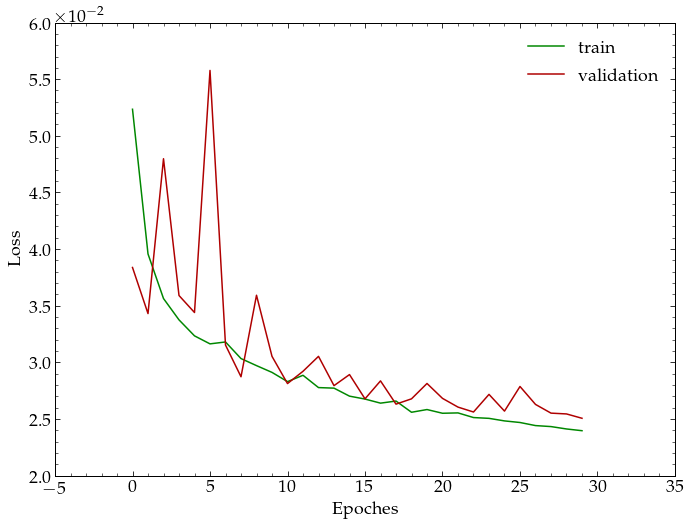

In [37]:
plt.plot(total_train_loss, label='train')
plt.plot(total_val_loss, label='validation')
plt.legend()
plt.xlabel('Epoches')
plt.ylabel('Loss')

In [36]:
predictions = np.load('/content/drive/MyDrive/ml4pion/model/GNN2.npz', allow_pickle=True)
targets_regress = predictions['targets'][0][:, 0]
targets_class = predictions['targets'][0][:, 1]
outputs_regress = predictions['outputs'][0][:, 0]
outputs_class = predictions['outputs'][0][:, 1]